# Imports

In [1]:
from functions import *

# Setup Spark

In [2]:
file = "data/US_Accidents_Dec19.csv"
model_indexing_dir = "log_index.md"
models_dir = "analysis"
logs_dir = "analysis" 
images_dir = "analysis"
model_Note = 'Analysis tool'
log_mode=True
debug_mode=False
enable_plots = True

logger = logging(models_dir, logs_dir, images_dir, "Analysis", enabled=log_mode)

df,sc, spark = setup_spark(file=file)

In [3]:
sc

<SparkContext master=local[*] appName=Spark Project>

In [4]:
tmp = sc._conf.getAll()
logger.write2file("New Spark session", str(tmp))
print("Config:",tmp)

Config: [('spark.driver.memory', '4g'), ('spark.rdd.compress', 'True'), ('spark.executor.memory', '4g'), ('spark.driver.host', '4082e07eadd9'), ('spark.app.id', 'local-1589592811980'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.driver.port', '42357'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.driver.maxResultSize', '3g'), ('spark.app.name', 'Spark Project'), ('spark.ui.showConsoleProgress', 'true')]


# Define variables

In [5]:
colLabel = ["Severity"]

colRem = ['ID', 
          'Source',
          'End_Time',
          'End_Lat',
          'End_Lng',
          'Description',
        ]

df, colCat, colNum = setup_variables(df, sc, colLabel, colRem)    

logger.write2file("Number of rows", str(df.count()))
logger.write2file("Categorical groups","Defined Label:\n" + str(colLabel) + "\nDefined Categories:\n" + str(colCat) + "\nDefined Numerical:\n" +str(colNum))

Label: ['Severity'] 
Categories: ['Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
Numerical: ['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']


# 1. Analysis

In [6]:
print(f"Categories:\n \
Labels: {len(colLabel)}\n \
Classes: {len(colCat)}\n \
Removed: {len(colRem)}\n \
Numerical: {len(colNum)}") 

info = f"Rows: {df.count()}\nColumns {len(df.columns)}"
print(info)
df.printSchema()
df.take(1)

logger.write2file("Data analysis",info +"\n"+ str(df._jdf.schema().treeString()) + str(df.take(1)))

Categories:
 Labels: 1
 Classes: 28
 Removed: 6
 Numerical: 12
Rows: 2925212
Columns 43
root
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)

## Statistical summary

In [7]:
df.describe(colNum).show()

+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+
|summary|               TMC|        Start_Lat|         Start_Lng|       Distance(mi)|            Number|    Temperature(F)|    Wind_Chill(F)|       Humidity(%)|      Pressure(in)|   Visibility(mi)| Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+----------------+--------------------+
|  count|           2246264|          2925212|           2925212|            2925211|           1044257|           2870369|          1074342|           2867292|           2878158|          2860864|         2485981|              929628|
|   mean|207.83163198982845|36.45789080583485|-95.314806

## Get missing data

In [8]:
printMissingValues(df, logger)

Missing valuesroot
 |-- TMC: long (nullable = false)
 |-- Severity: long (nullable = false)
 |-- Start_Time: long (nullable = false)
 |-- Start_Lat: long (nullable = false)
 |-- Start_Lng: long (nullable = false)
 |-- Distance(mi): long (nullable = false)
 |-- Number: long (nullable = false)
 |-- Street: long (nullable = false)
 |-- Side: long (nullable = false)
 |-- City: long (nullable = false)
 |-- County: long (nullable = false)
 |-- State: long (nullable = false)
 |-- Zipcode: long (nullable = false)
 |-- Country: long (nullable = false)
 |-- Timezone: long (nullable = false)
 |-- Airport_Code: long (nullable = false)
 |-- Weather_Timestamp: long (nullable = false)
 |-- Temperature(F): long (nullable = false)
 |-- Wind_Chill(F): long (nullable = false)
 |-- Humidity(%): long (nullable = false)
 |-- Pressure(in): long (nullable = false)
 |-- Visibility(mi): long (nullable = false)
 |-- Wind_Direction: long (nullable = false)
 |-- Wind_Speed(mph): long (nullable = false)
 |-- Precip

## Get categorical values

In [9]:
df.persist()
tmp = [df.select(countDistinct(c).alias(c)).collect()[0] for c in [*colCat]] 
df.unpersist()
print("Unique column values:", tmp)

logger.write2file("Unique column values", str(tmp))

Unique column values: [Row(Street=159491), Row(Side=3), Row(City=11631), Row(County=1704), Row(State=49), Row(Zipcode=374288), Row(Country=1), Row(Timezone=4), Row(Airport_Code=1990), Row(Wind_Direction=24), Row(Weather_Condition=119), Row(Amenity=2), Row(Bump=2), Row(Crossing=2), Row(Give_Way=2), Row(Junction=2), Row(No_Exit=2), Row(Railway=2), Row(Roundabout=2), Row(Station=2), Row(Stop=2), Row(Traffic_Calming=2), Row(Traffic_Signal=2), Row(Turning_Loop=1), Row(Sunrise_Sunset=2), Row(Civil_Twilight=2), Row(Nautical_Twilight=2), Row(Astronomical_Twilight=2)]


## Correlation

In [10]:
print([*colNum, *colLabel])

['TMC', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Number', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Severity']


In [11]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=colNum,
    outputCol="features",
    handleInvalid = "skip")

df_attributes = assembler.transform(df)
df_attributes.select("features").show(1,False)



r1 = Correlation.corr(df_attributes, "features").head()

print("correlation matrix:\n" + str(r1[0]))

logger.write2file("Correlation matrix", str(r1[0]))

+---------------------------------------------------------------------------+
|features                                                                   |
+---------------------------------------------------------------------------+
|[201.0,39.972038,-82.913521,0.01,3280.0,37.4,33.8,100.0,29.62,3.0,4.6,0.02]|
+---------------------------------------------------------------------------+
only showing top 1 row

correlation matrix:
DenseMatrix([[ 1.00000000e+00, -3.29968079e-02, -4.23709318e-02,
               6.48521350e-02,  4.88102771e-02,  2.89427459e-02,
               3.07391705e-02, -6.70493470e-03,  4.59513996e-03,
               2.21819466e-02, -1.61669692e-03, -1.80310455e-03],
             [-3.29968079e-02,  1.00000000e+00, -5.22492702e-03,
               5.01751676e-02, -3.17558810e-02, -4.68351247e-01,
              -4.69159899e-01,  9.79378608e-02, -1.18202158e-01,
              -1.54998940e-01,  9.15359600e-02,  5.03876348e-03],
             [-4.23709318e-02, -5.22492702e-

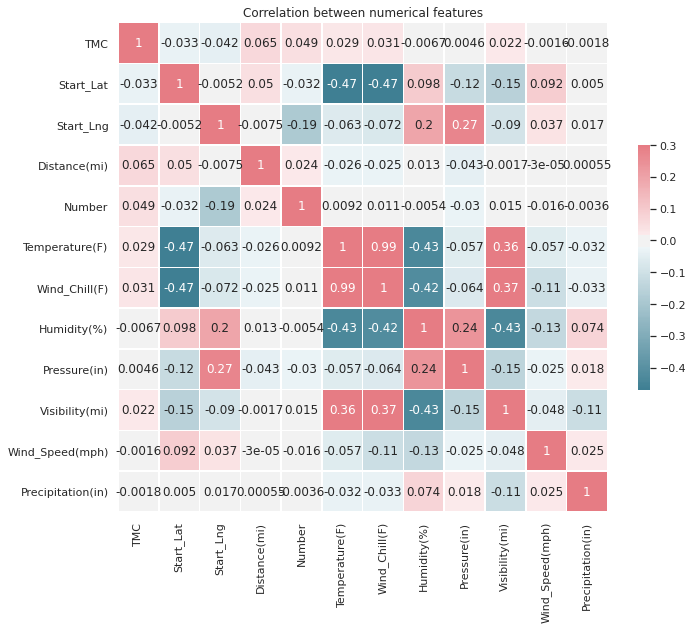

In [12]:
if enable_plots == True:
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    b = sns.heatmap(r1[0].toArray().tolist(), annot=True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=colNum,yticklabels=colNum,ax=ax )
    ax.set_title("Correlation between numerical features")

    logger.saveImage(b,"feature_corr_matrix")

## Severity

In [13]:
severity_freq = df.groupBy('Severity').count().orderBy('count',ascending=False)
severity_freq.take(10) 

[Row(Severity=2, count=1959478),
 Row(Severity=3, count=878985),
 Row(Severity=4, count=85781),
 Row(Severity=1, count=968)]

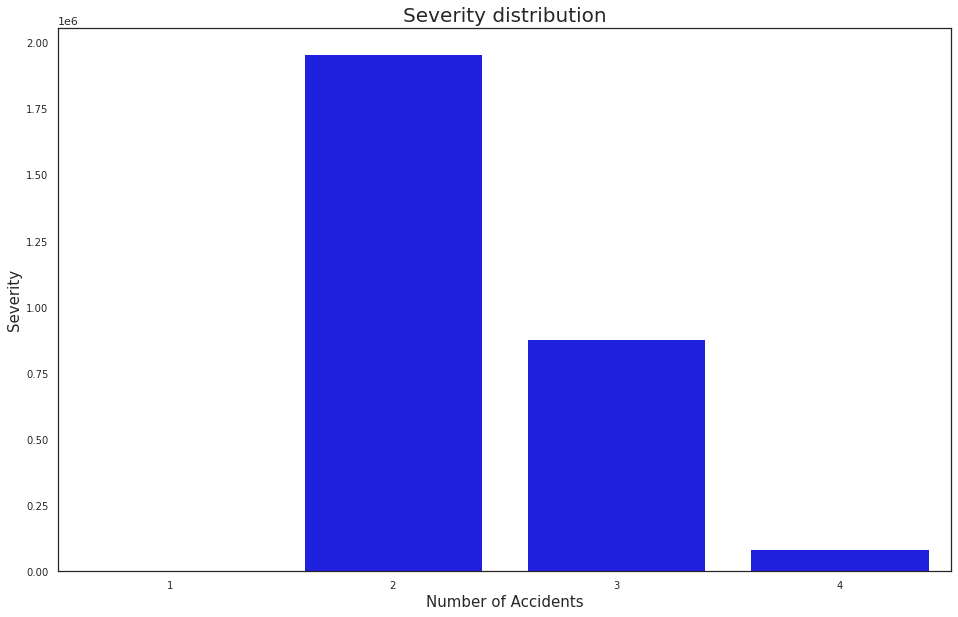

In [14]:
if enable_plots == True:
    pd_severity = severity_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(pd_severity['Severity'],pd_severity['count'], color='blue')
    b.axes.set_title("Severity distribution",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("Severity",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist")

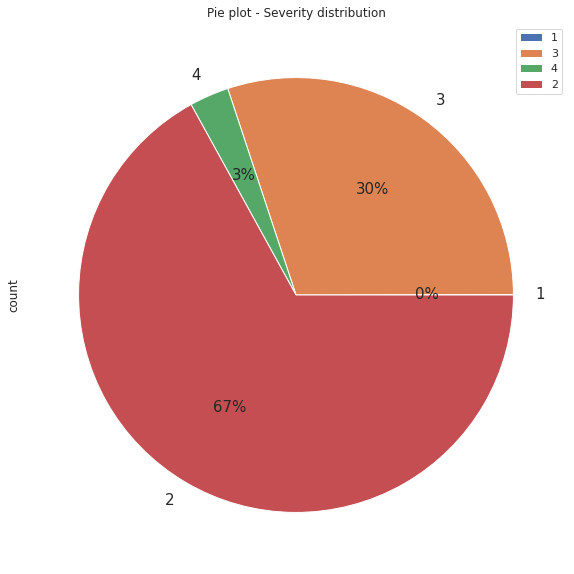

In [15]:
if enable_plots == True:
    df_sev = df.groupby('Severity').count().toPandas()
    fig = df_sev.plot.pie(y='count', labels=df_sev['Severity'], figsize=(10, 10), autopct='%1.0f%%',title="Pie plot - Severity distribution",fontsize=15)
    logger.saveImage(fig,"pie_severity_dist")
    

## Causes

### Frequency of severity and state

In [16]:
state_freq = df.groupBy('State').count().orderBy('count',ascending=False)
state_freq.take(10)

[Row(State='CA', count=653172),
 Row(State='TX', count=296044),
 Row(State='FL', count=220711),
 Row(State='SC', count=146340),
 Row(State='NC', count=141384),
 Row(State='NY', count=135622),
 Row(State='PA', count=90015),
 Row(State='MI', count=87425),
 Row(State='IL', count=84759),
 Row(State='GA', count=82073)]

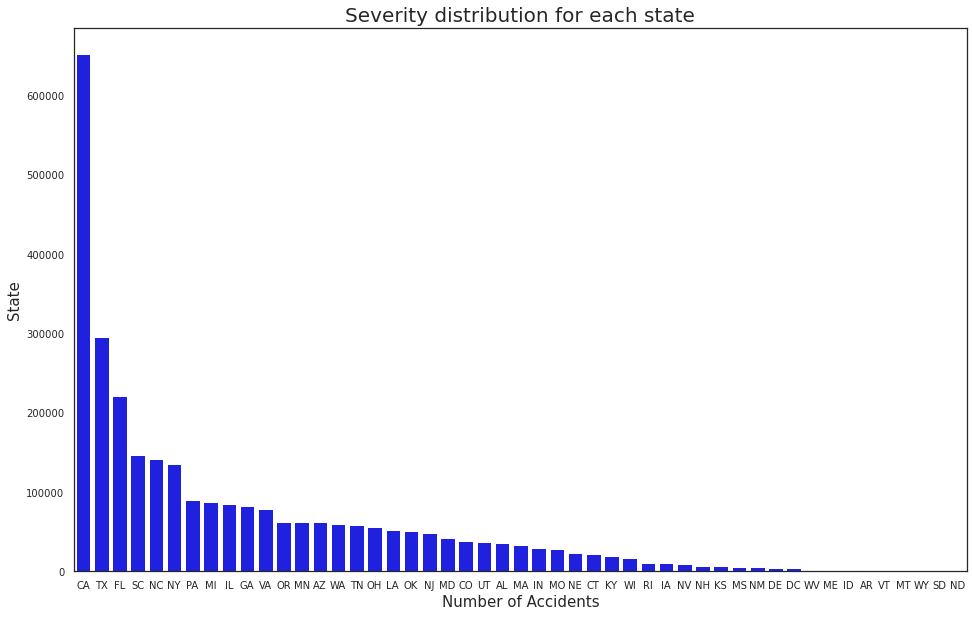

In [17]:
if enable_plots == True:
    pd_states = state_freq.toPandas()
    
    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(pd_states['State'],pd_states['count'], color='blue')
    b.axes.set_title("Severity distribution for each state",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("State",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist_state")

In [18]:
state_severity_freq = df.groupBy('State','Severity').count().orderBy('count',ascending=False)
state_severity_freq.take(10)

[Row(State='CA', Severity=2, count=436981),
 Row(State='TX', Severity=2, count=214216),
 Row(State='CA', Severity=3, count=210069),
 Row(State='FL', Severity=2, count=142957),
 Row(State='NC', Severity=2, count=120643),
 Row(State='SC', Severity=2, count=114096),
 Row(State='NY', Severity=2, count=80954),
 Row(State='TX', Severity=3, count=78460),
 Row(State='FL', Severity=3, count=70953),
 Row(State='PA', Severity=2, count=67629)]

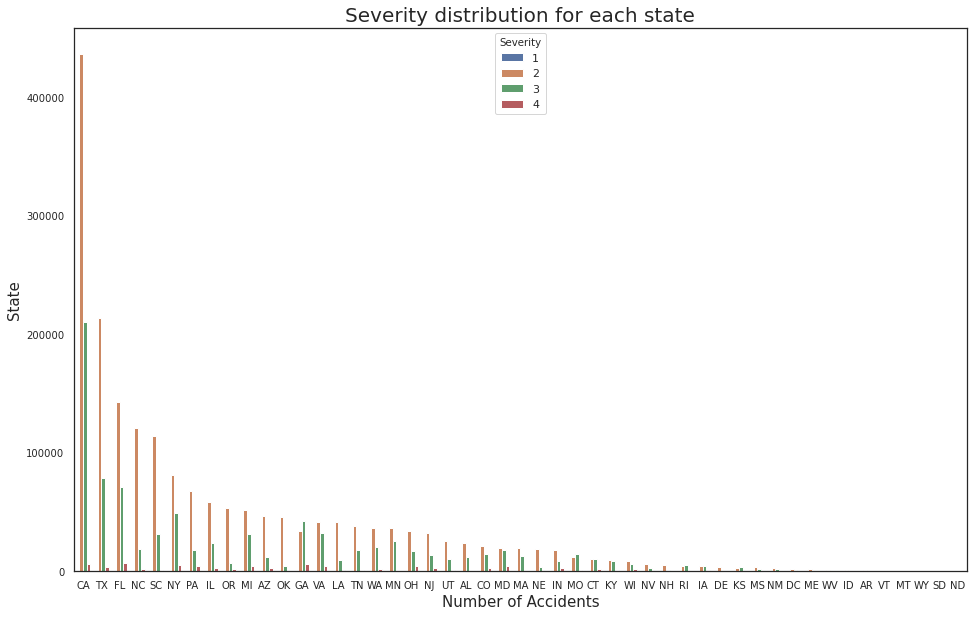

In [20]:
if enable_plots == True:
    pd_state_severity = state_severity_freq.toPandas()
    
    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))
    b = sns.barplot(x="State", y="count", hue="Severity", data=pd_state_severity)
    #b = sns.barplot(pd_state_severity['State', 'Severity'],pd_state_severity['count'])
    b.axes.set_title("Severity distribution for each state",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("State",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"severity_dist_class_state")

### Weather conditions

In [22]:
weather_freq = df.groupBy('Weather_Condition').count().orderBy('count',ascending=False)
weather_freq.take(10)

[Row(Weather_Condition='Clear', count=808171),
 Row(Weather_Condition='Mostly Cloudy', count=405136),
 Row(Weather_Condition='Overcast', count=382479),
 Row(Weather_Condition='Fair', count=311864),
 Row(Weather_Condition='Partly Cloudy', count=288380),
 Row(Weather_Condition='Scattered Clouds', count=204662),
 Row(Weather_Condition='Light Rain', count=139622),
 Row(Weather_Condition='Cloudy', count=109817),
 Row(Weather_Condition=None, count=64557),
 Row(Weather_Condition='Light Snow', count=42109)]

[Row(Weather_Condition='Clear', count=808171), Row(Weather_Condition='Mostly Cloudy', count=405136), Row(Weather_Condition='Overcast', count=382479), Row(Weather_Condition='Fair', count=311864), Row(Weather_Condition='Partly Cloudy', count=288380), Row(Weather_Condition='Scattered Clouds', count=204662), Row(Weather_Condition='Light Rain', count=139622), Row(Weather_Condition='Cloudy', count=109817), Row(Weather_Condition=None, count=64557), Row(Weather_Condition='Light Snow', count=42109), Row(Weather_Condition='Haze', count=33932), Row(Weather_Condition='Rain', count=32585), Row(Weather_Condition='Fog', count=21853), Row(Weather_Condition='Heavy Rain', count=11966), Row(Weather_Condition='Light Drizzle', count=10201), Row(Weather_Condition='Light Thunderstorms and Rain', count=4928), Row(Weather_Condition='Snow', count=4795), Row(Weather_Condition='Thunderstorm', count=4438), Row(Weather_Condition='Smoke', count=3558), Row(Weather_Condition='Fair / Windy', count=3547)]


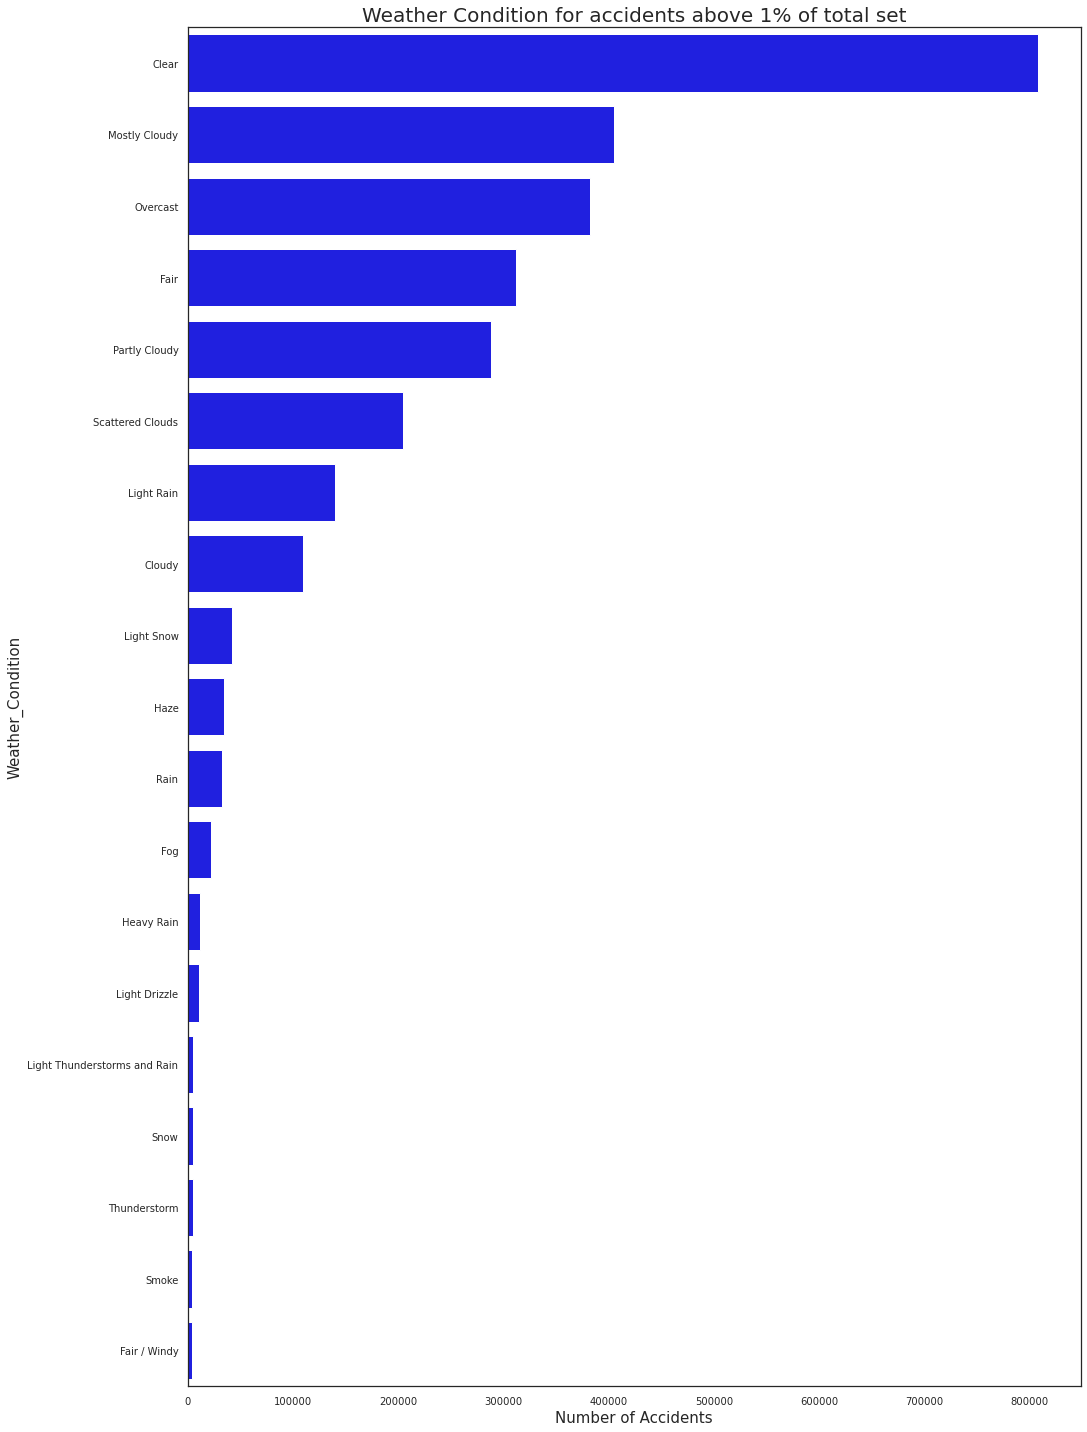

In [24]:

n = int(df.count()*0.001) # Limit the plot to ignore conditions below an limit

rdd_filtered = weather_freq.rdd.filter(lambda x: x['count'] > n)
print(rdd_filtered.collect())

if enable_plots == True:
    fig, ax=plt.subplots(figsize=(16,25))
    pd_weather = rdd_filtered.toDF().toPandas()

    b = sns.barplot(pd_weather['count'][:],pd_weather['Weather_Condition'][:], color="blue")

    b.axes.set_title("Weather Condition for accidents above 1% of total set",fontsize=20)
    b.set_xlabel("Number of Accidents",fontsize=15)
    b.set_ylabel("Weather_Condition",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"weather_cond_dist")
    logger.write2file("Weather condition distribution", str(pd_weather))

### Time when accidents occured

In [26]:
df_time = df.selectExpr("hour(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False)
time_freq.take(10)


[Row(Start_Time=3, count=249235),
 Row(Start_Time=2, count=225145),
 Row(Start_Time=4, count=207490),
 Row(Start_Time=11, count=182422),
 Row(Start_Time=12, count=182094),
 Row(Start_Time=10, count=177869),
 Row(Start_Time=1, count=166845),
 Row(Start_Time=9, count=161333),
 Row(Start_Time=5, count=159849),
 Row(Start_Time=13, count=152495)]

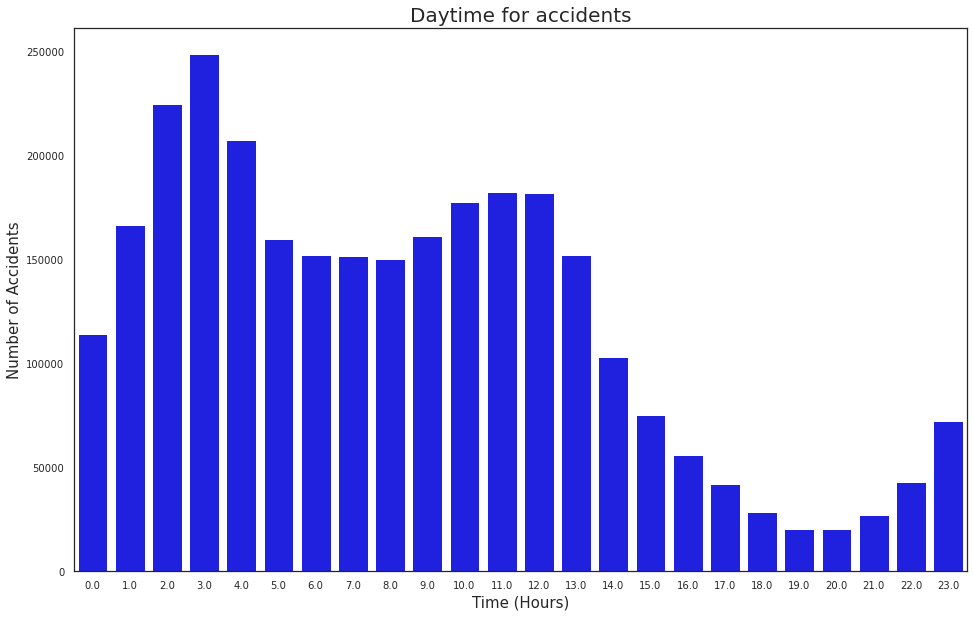

In [27]:
if enable_plots == True:
    pd_time = time_freq.toPandas()
 
    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))

    b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
    b.axes.set_title("Daytime for accidents",fontsize=20)
    b.set_xlabel("Time (Hours)",fontsize=15)
    b.set_ylabel("Number of Accidents",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"accident_hours")

### Development of accidents on Month basis

In [ ]:
df_time = df.selectExpr("month(to_timestamp(from_utc_timestamp(Start_Time, Timezone), 'yyyy-MM-dd HH:mm:ss')) as Start_Time")
time_freq = df_time.groupBy('Start_Time').count().orderBy('count',ascending=False)
time_freq.take(10)

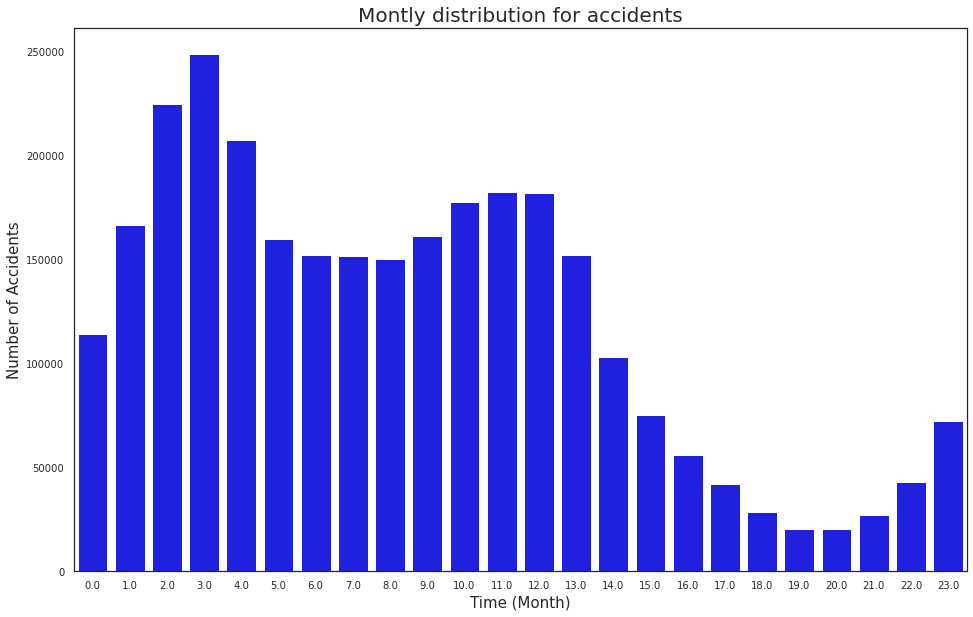

In [28]:
if enable_plots == True:
    pd_time = time_freq.toPandas()

    # Plot data
    fig,ax = plt.subplots(figsize=(16,10))

    b = sns.barplot(pd_time['Start_Time'],pd_time['count'], color='blue')
    b.axes.set_title("Montly distribution for accidents",fontsize=20)
    b.set_xlabel("Time (Month)",fontsize=15)
    b.set_ylabel("Number of Accidents",fontsize=15)
    b.tick_params(labelsize=10)

    logger.saveImage(b,"accudents_months")

### Map distribution

In [ ]:
if enable_plots == True:
    b = sns.jointplot(x=df.select(collect_list('Start_Lat')).first()[0],y=df.select(collect_list('Start_Lng')).first()[0],height=10)

    b.set_axis_labels('Start_Lat','Start_Lng')
    b.fig.suptitle("Map distribution of accidents")
    logger.saveImage(b,"accident_map_dist")

In [ ]:
logger.write2file("New Analysis created!", \
               "Model finished: Yes" + \
               "\nFolder name: " + logger.timeSignature + \
               "\nState: "+ "Not defined" + \
               "\nLogs directory: " + logger.logs_dir +  \
               "\nFile: " + file + \
               "\nNote: " + model_Note, \
               logs_dir=model_indexing_dir \
              )